In [1]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle
import gc


import matplotlib.backend_bases
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.gridspec as gridspec

# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# HDC models

In [2]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'

bin_size = 160  # ms
single_spikes = False

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

units:  85  hdc units:  22


In [3]:
checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below

models_test_ll = np.zeros((4, 4))
models_train_ll = np.zeros((4, 4))

for i, mode in enumerate(['ew', 'ec', 'eq', 'qd']):
    for j, U in enumerate([1, 2, 3, 4]):
        ll_mode = 'U-' + mode + '-' + str(U)
        model_dict['ll_mode'] = ll_mode
        
        total_test_ll = 0
        total_train_ll = 0
        num_cvs = 0
        for cv_run in [0, 1, 2, 3, 4]:
            # model and train/test split based on which validation fold is given by cv_run
            try:
                modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

                ll = lib.helper.RG_pred_ll(
                    modelfit, validation_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_test_ll += ll
                num_cvs += 1

                ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_train_ll += ll
            except FileNotFoundError:
                print(f'Model {ll_mode} with cv_run={cv_run} not found.')
    
        models_test_ll[j, i] = total_test_ll / num_cvs
        models_train_ll[j, i] = total_train_ll / num_cvs

models_test_ll_hdc = models_test_ll
models_train_ll_hdc = models_train_ll

Model U-ec-2 with cv_run=0 not found.
Model U-eq-4 with cv_run=3 not found.
Model U-qd-4 with cv_run=2 not found.


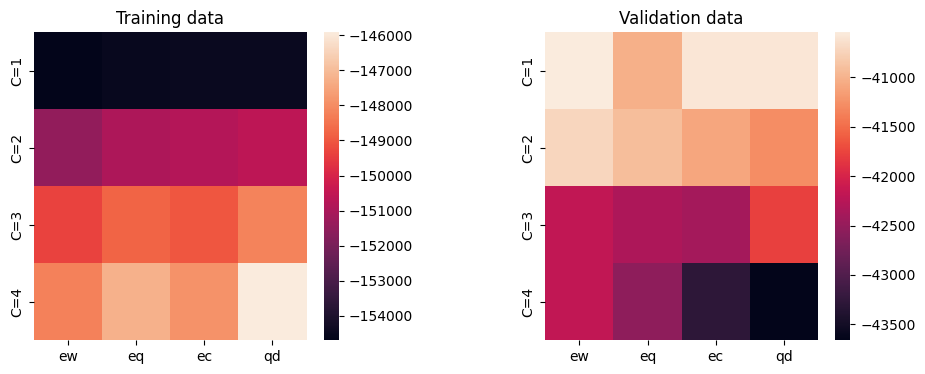

In [4]:
fig = plt.figure(figsize=(11, 4))

gs = gridspec.GridSpec(1, 2, fig, wspace=0.5)

data_train = pd.DataFrame(models_train_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
ax = fig.add_subplot(gs[0])
sns.heatmap(data_train, ax=ax)
ax.set_title('Training data')

data_test = pd.DataFrame(models_test_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
ax = fig.add_subplot(gs[1])
sns.heatmap(data_test, ax=ax)
ax.set_title('Validation data')

plt.savefig("/homes/vn283/UCM-interpret/figures/model_selection_hd.pdf", format="pdf", bbox_inches="tight")

# Non-HDC models

In [5]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'nonhdc'
phase = 'wake'

bin_size = 160  # ms
single_spikes = False

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }                                              

units:  85  hdc units:  22


In [6]:
checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
delay = 0
batch_size = 500  # size of time segments of each batch in dataset below

models_test_ll = np.zeros((3, 4))
models_train_ll = np.zeros((3, 4))

for i, mode in enumerate(['ew', 'eq', 'ec', 'qd']):
    for j, C in enumerate([1, 2, 3]):
        ll_mode = 'U-' + mode + '-' + str(C)
        model_dict['ll_mode'] = ll_mode
        
        total_test_ll = 0
        total_train_ll = 0
        num_cvs = 0
        for cv_run in [0, 1, 2, 3, 4]:
            # model and train/test split based on which validation fold is given by cv_run
            try:
                modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev
                )

                ll = lib.helper.RG_pred_ll(
                    modelfit, validation_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_test_ll += ll
                num_cvs += 1

                ll = lib.helper.RG_pred_ll(
                    modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                    ll_samples=1, cov_samples=1, beta=0.0
                )
                total_train_ll += ll
            except FileNotFoundError:
                print(f'Model {ll_mode} with cv_run={cv_run} not found.')
    
        models_test_ll[j, i] = total_test_ll / num_cvs
        models_train_ll[j, i] = total_train_ll / num_cvs



Model U-ew-3 with cv_run=3 not found.


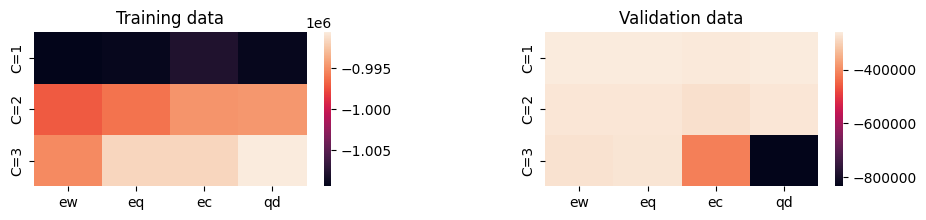

In [7]:
fig = plt.figure(figsize=(11, 2))

gs = gridspec.GridSpec(1, 2, fig, wspace=0.5)

data_train = pd.DataFrame(models_train_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1', 'C=2','C=3'])
ax = fig.add_subplot(gs[0])
sns.heatmap(data_train, ax=ax)
ax.set_title('Training data')

data_test = pd.DataFrame(models_test_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3'])
ax = fig.add_subplot(gs[1])
sns.heatmap(data_test, ax=ax)
ax.set_title('Validation data')

plt.savefig("/homes/vn283/UCM-interpret/figures/model_selection_nonhd.pdf", format="pdf", bbox_inches="tight")

# Plot for report

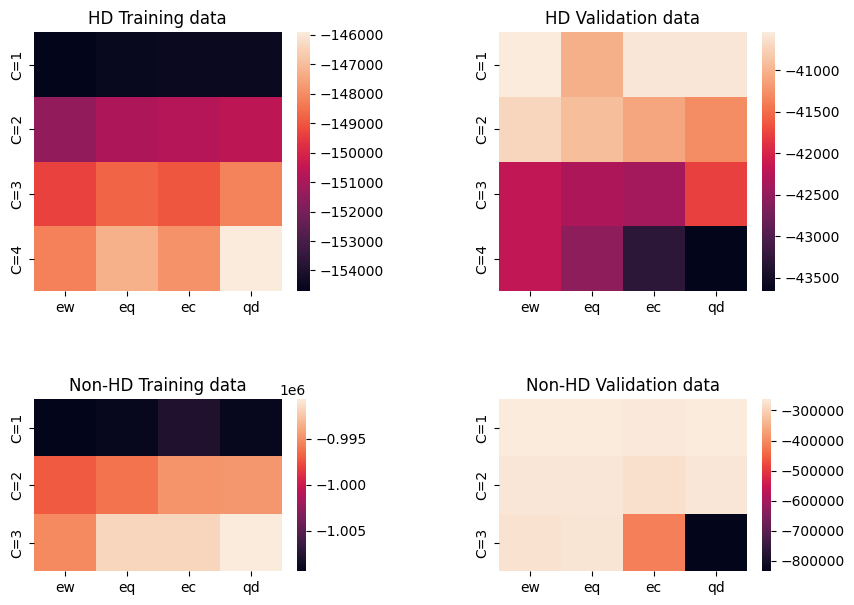

In [20]:
fig = plt.figure(figsize=(10, 7))

gs = gridspec.GridSpec(2, 2, fig, wspace=0.5, height_ratios=[3,2], hspace=0.5)

data_train = pd.DataFrame(models_train_ll_hdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
ax = fig.add_subplot(gs[0,0])
sns.heatmap(data_train, ax=ax)
ax.set_title('HD Training data')

data_test = pd.DataFrame(models_test_ll_hdc, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3','C=4'])
ax = fig.add_subplot(gs[0,1])
sns.heatmap(data_test, ax=ax)
ax.set_title('HD Validation data')

data_train = pd.DataFrame(models_train_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1', 'C=2','C=3'])
ax = fig.add_subplot(gs[1,0])
sns.heatmap(data_train, ax=ax)
ax.set_title('Non-HD Training data')

data_test = pd.DataFrame(models_test_ll, columns=['ew', 'eq', 'ec', 'qd'], index=['C=1','C=2','C=3'])
ax = fig.add_subplot(gs[1,1])
sns.heatmap(data_test, ax=ax)
ax.set_title('Non-HD Validation data')

plt.savefig("/homes/vn283/UCM-interpret/figures/model_selection.pdf", format="pdf", bbox_inches="tight")

# Inspect a model

In [8]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'nonhdc'
phase = 'wake'

bin_size = 160  # ms
single_spikes = False

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }                          

units:  85  hdc units:  22


In [9]:
model_dict['ll_mode'] = 'U-ec-2'
cv_run = 0

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev)

In [10]:
ne = 20  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()

Wn.shape

(103, 8)

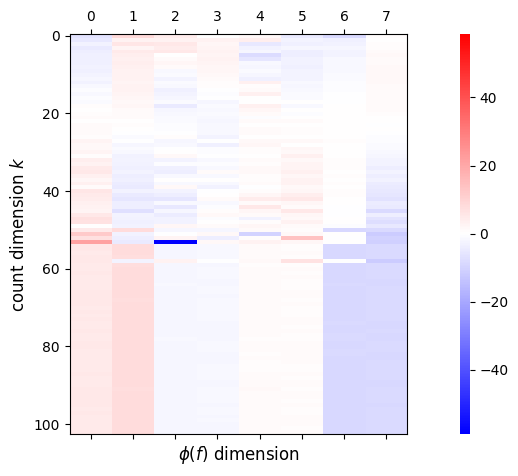

In [11]:
ne = 20  # select neuron
Wn = modelfit.likelihood.mapping_net.mnet.net[0].weight[ne, :, :].data.cpu().numpy()

Wmax = max(-Wn.min(), Wn.max())


fig = plt.figure(figsize=(4, 4))
widths = [1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 0])
utils.plot.decorate_ax(ax)  # get all four spines around plot
im = ax.matshow(Wn, vmin=-Wmax, vmax=Wmax, cmap=weight_map, aspect='auto')
ax.set_xlabel(r'$\phi(f)$ dimension')
ax.set_ylabel(r'count dimension $k$')

ax = fig.add_subplot(spec[0, 1])
utils.plot.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)
    
plt.show()

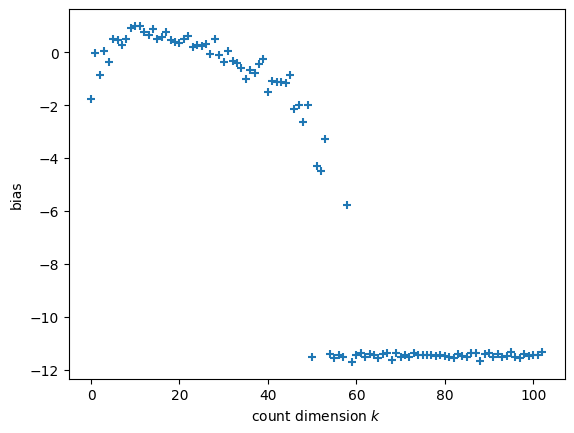

In [12]:
bn = modelfit.likelihood.mapping_net.mnet.net[0].bias[ne, :].data.cpu().numpy()

fig, ax = plt.subplots()
ax.scatter(np.arange(bn.shape[0]), bn, marker='+', s=30)
ax.set_ylabel('bias')
ax.set_xlabel(r'count dimension $k$')
plt.show()

In [13]:
#del modelfit
#gc.collect()
#torch.cuda.empty_cache()